In [1]:
import pandas as pd
import numpy as np
from scipy.stats import scoreatpercentile

df = pd.read_csv('/Users/dhruvsuri/Code/US_emissions_impacts/data/CEMS/ERCOT/emissions-hourly-2018-tx.csv')

df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')
df['Datetime'] = df['Date'] + df['Hour']
coal_fuel = ['Coal']
gas_fuel = ['Natural Gas','Pipeline Natural Gas']
df = df[df['Primary Fuel Type'].isin(gas_fuel)]
columns = ['Facility ID', 'Unit ID', 'Datetime', 'CO2 Mass (short tons)', 'Gross Load (MW)', 'Operating Time']
df_mod = df[columns]

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/3404999446.py:5: DtypeWarning: Columns (3,4,11,13,15,17,19,21,23,25,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/dhruvsuri/Code/US_emissions_impacts/data/CEMS/ERCOT/emissions-hourly-2018-tx.csv')


In [2]:
df_grouped = df_mod.copy()
# drop Unit ID
df_grouped = df_grouped.drop(['Unit ID'], axis=1)
# convert Gross Load and CO2 Mass to numeric
df_grouped['Gross Load (MW)'] = pd.to_numeric(df_grouped['Gross Load (MW)'], errors='coerce')
df_grouped['CO2 Mass (short tons)'] = pd.to_numeric(df_grouped['CO2 Mass (short tons)'], errors='coerce')
df_grouped = df_grouped.groupby(['Facility ID', 'Datetime']).sum().reset_index()

df_grouped['CO2 Mass (short tons)'] = df_grouped['CO2 Mass (short tons)'] * 0.907185
df_grouped['EI'] = df_grouped['CO2 Mass (short tons)'] / df_grouped['Gross Load (MW)']

# replace inf with nan and drop
df_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
df_grouped.dropna(inplace=True)

df_summary = df_grouped.groupby('Facility ID').agg({'EI': ['mean', 'median',
                                                           lambda x: scoreatpercentile(x,90),
                                                           lambda x: scoreatpercentile(x,10)],
                                                           'Gross Load (MW)': 'sum',
                                                           'CO2 Mass (short tons)': 'sum'}).reset_index()

df_summary.columns = ['Facility ID', 'Mean EI', 'Median EI', '90th Percentile EI', '10th Percentile EI', 'Total Gross Load (MW)', 'Total CO2 Mass (short tons)']
df_summary['Mean Annual EI'] = df_summary['Total CO2 Mass (short tons)'] / df_summary['Total Gross Load (MW)']

df_summary['P90 emissions'] = df_summary['90th Percentile EI'] * df_summary['Total Gross Load (MW)']
df_summary['P10 emissions'] = df_summary['10th Percentile EI'] * df_summary['Total Gross Load (MW)']

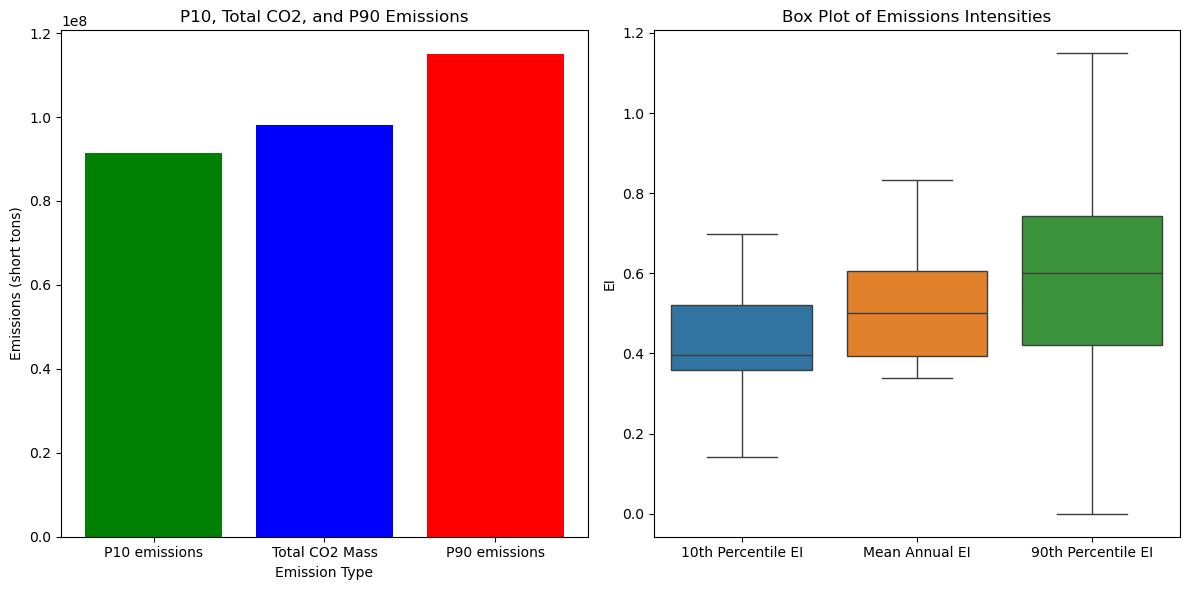

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the bar plot on the left and box plot on the right
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Assuming df_summary contains the following columns:
# 'P10 emissions', 'Total CO2 Mass (short tons)', 'P90 emissions'

# Bar plot on the left for P10 emissions, Total CO2 Mass, and P90 emissions
ax1.bar(['P10 emissions', 'Total CO2 Mass', 'P90 emissions'], 
        df_summary[['P10 emissions', 'Total CO2 Mass (short tons)', 'P90 emissions']].sum(), 
        color=['green', 'blue', 'red'])

# Customizing the bar chart
ax1.set_xlabel('Emission Type')
ax1.set_ylabel('Emissions (short tons)')
ax1.set_title('P10, Total CO2, and P90 Emissions')

# Box plot on the right
# Box plot of '10th Percentile EI', 'Mean Annual EI', and '90th Percentile EI' from df_summary
sns.boxplot(data=df_summary[['10th Percentile EI', 'Mean Annual EI', '90th Percentile EI']], showfliers=False, ax=ax2)

# Customizing the box plot
ax2.set_ylabel('EI')
ax2.set_title('Box Plot of Emissions Intensities')

# Adjust layout
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import scoreatpercentile
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# List of CSV file paths for each year (assuming files are named like 'emissions-hourly-2018-tx.csv', etc.)
file_paths = glob.glob('/Users/dhruvsuri/Code/US_emissions_impacts/data/fig1/emissions-hourly-*-combined-ERCOT.csv')

# Create an empty DataFrame to hold all years' data
df_summary_all_years = pd.DataFrame()

for file_path in file_paths:
    # Load the data for each year
    df = pd.read_csv(file_path)
    
    # Preprocess the data
    df['Date'] = pd.to_datetime(df['Date'])
    df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')
    df['Datetime'] = df['Date'] + df['Hour']
    df['Year'] = df['Datetime'].dt.year
    coal_fuel = ['Coal']
    gas_fuel = ['Natural Gas','Pipeline Natural Gas']
    df = df[df['Primary Fuel Type'].isin(coal_fuel)]
    columns = ['Facility ID', 'Unit ID', 'Datetime', 'CO2 Mass (short tons)', 'Gross Load (MW)', 'Operating Time', 'Year']
    df_mod = df[columns]
    
    # Drop 'Unit ID' and handle numeric conversions
    df_grouped = df_mod.drop(['Unit ID'], axis=1)
    df_grouped['Gross Load (MW)'] = pd.to_numeric(df_grouped['Gross Load (MW)'], errors='coerce')
    df_grouped['CO2 Mass (short tons)'] = pd.to_numeric(df_grouped['CO2 Mass (short tons)'], errors='coerce')
    
    # Group data by Facility ID and Datetime, summing emissions
    df_grouped = df_grouped.groupby(['Facility ID', 'Datetime']).sum().reset_index()
    
    # Convert CO2 Mass to metric tons and calculate EI
    df_grouped['CO2 Mass (short tons)'] = df_grouped['CO2 Mass (short tons)'] * 0.907185
    df_grouped['EI'] = df_grouped['CO2 Mass (short tons)'] / df_grouped['Gross Load (MW)']
    
    # Replace infinite and NaN values
    df_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_grouped.dropna(inplace=True)
    # drop when EI is 0
    df_grouped = df_grouped[df_grouped['EI'] != 0]
    
    # Group by Facility ID and calculate statistics
    df_summary = df_grouped.groupby('Facility ID').agg({
        'EI': ['mean', 'median', lambda x: scoreatpercentile(x, 90), lambda x: scoreatpercentile(x, 10)],
        'Gross Load (MW)': 'sum',
        'CO2 Mass (short tons)': 'sum'
    }).reset_index()

    # Rename columns
    df_summary.columns = ['Facility ID', 'Mean EI', 'Median EI', '90th Percentile EI', '10th Percentile EI', 'Total Gross Load (MW)', 'Total CO2 Mass (short tons)']
    df_summary['Mean Annual EI'] = df_summary['Total CO2 Mass (short tons)'] / df_summary['Total Gross Load (MW)']
    df_summary['P90 emissions'] = df_summary['90th Percentile EI'] * df_summary['Total Gross Load (MW)']
    df_summary['P10 emissions'] = df_summary['10th Percentile EI'] * df_summary['Total Gross Load (MW)']
    
    # Add year column to summary
    df_summary['Year'] = df_grouped['Datetime'].dt.year.iloc[0]  # Use first row's year since all data belongs to the same year
    
    # Append to the master DataFrame
    df_summary_all_years = pd.concat([df_summary_all_years, df_summary], ignore_index=True)

    years = [2018,2019,2020,2021,2022,2023]

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_57397/2016822087.py:16: DtypeWarning: Columns (3,4,11,13,15,17,25,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_57397/2016822087.py:16: DtypeWarning: Columns (3,4,11,13,15,17,25,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_57397/2016822087.py:16: DtypeWarning: Columns (3,4,11,13,15,17,19,25,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_57397/2016822087.py:16: DtypeWarning: Columns (3,4,11,13,15,17,25,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3

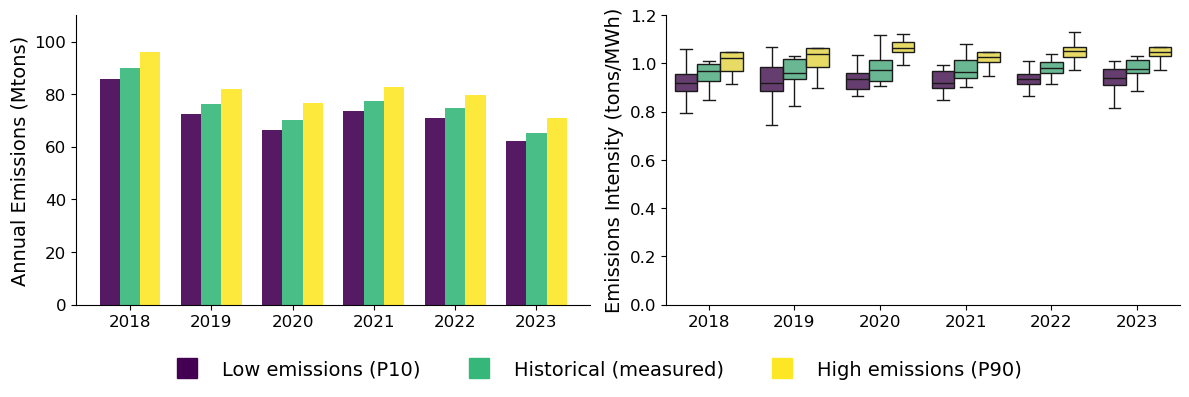

In [5]:
# Plot the bar plot on the left and box plot on the right
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3.5))

colors_viridis = plt.cm.viridis(np.linspace(0, 1, 4))

# Bar plot for P10 emissions, Total CO2 Mass, and P90 emissions by year
#for i, year in enumerate(years):
#    df_year = df_summary_all_years[df_summary_all_years['Year'] == year]
#    ax1.bar(i - 0.25, df_year['P10 emissions'].sum()/ 1e6, width=0.25, label=f'P10 {year}', color='#a1c4e9')
#    ax1.bar(i, df_year['Total CO2 Mass (short tons)'].sum()/ 1e6, width=0.25, label=f'Total CO2 {year}', color='#999999')
#    ax1.bar(i + 0.25, df_year['P90 emissions'].sum()/ 1e6, width=0.25, label=f'P90 {year}', color='#ee9a01')

for i, year in enumerate(years):
    df_year = df_summary_all_years[df_summary_all_years['Year'] == year]
    ax1.bar(i - 0.25, df_year['P10 emissions'].sum()/ 1e6, width=0.25, label=f'P10 {year}', color=colors_viridis[0])
    ax1.bar(i, df_year['Total CO2 Mass (short tons)'].sum()/ 1e6, width=0.25, label=f'Total CO2 {year}', color=colors_viridis[2])
    ax1.bar(i + 0.25, df_year['P90 emissions'].sum()/ 1e6, width=0.25, label=f'P90 {year}', color=colors_viridis[3])

# Customizing the bar chart
ax1.set_xticks(range(len(years)))
ax1.set_xticklabels(years)
#ax1.set_xlabel('Year')
ax1.set_ylabel('Annual Emissions (Mtons)', fontsize=14)
#ax1.set_title('P10, Total CO2, and P90 Emissions by Year')

# Box plot of 10th Percentile EI, Mean Annual EI, and 90th Percentile EI for each year
df_summary_all_years_melted = pd.melt(df_summary_all_years, 
                                      id_vars='Year', 
                                      value_vars=['10th Percentile EI', 'Mean Annual EI', '90th Percentile EI'],
                                      var_name='EI Type', 
                                      value_name='EI Value')

lightened_colors = [
    list(colors_viridis[0][:3]) + [0.1],  # First color with 50% transparency
    list(colors_viridis[2][:3]) + [0.1],  # Second color with 50% transparency
    list(colors_viridis[3][:3]) + [0.1],  # Third color with 50% transparency
]
#sns.boxplot(x='Year', y='EI Value', hue='EI Type', data=df_summary_all_years_melted, ax=ax2, palette=[colors_viridis[1],
#                                                                                                      colors_viridis[2], colors_viridis[3]], showfliers=False)

sns.boxplot(x='Year', y='EI Value', hue='EI Type', data=df_summary_all_years_melted, 
            ax=ax2, palette=lightened_colors, showfliers=False)

for patch in ax2.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))

for patch in ax1.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))

# Customizing the box plot
ax2.set_ylabel('Emissions Intensity (tons/MWh)', fontsize=14)
#ax2.set_title('Box Plot of Emissions Intensities by Year')

# in both plots remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# hide x label of ax2
ax2.set_xlabel('')

# increase x label size of ax1 and ax2
ax1.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)

# increase y label size of ax1 and ax2
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

# set y range on ax2 from 0 to 1.2
ax2.set_ylim(0, 1.2)

ax1.set_ylim(0, 110)

# INCREASE y title size of ax1 and ax

# hide legend
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

# Custom legend for the bar plot
legend_entries = [
    ('Low emissions (P10)', colors_viridis[0]),
    ('Historical (measured)', colors_viridis[2]),
    ('High emissions (P90)', colors_viridis[3])
]

# Create square legend handles using marker properties
handles = [plt.Line2D([0], [0], marker='s', color=color, lw=0, markersize=14) for label, color in legend_entries]
labels = [label for label, color in legend_entries]

# Position the legend outside the plot at the bottom, horizontal layout
fig.legend(handles, labels, loc='lower center', fontsize=14, 
           title_fontsize='14', frameon=False, ncol=3, bbox_to_anchor=(0.5, -0.15), labelspacing=0.5)

# pad entries in the legend lesser


# Adjust layout
plt.tight_layout()
plt.show()

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/1975501259.py:21: DtypeWarning: Columns (3,4,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/1975501259.py:21: DtypeWarning: Columns (3,4,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/1975501259.py:21: DtypeWarning: Columns (3,4,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/1975501259.py:21: DtypeWarning: Columns (3,4,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/1975501259.py:21: DtypeWarning: Columns (3,4,25,28)

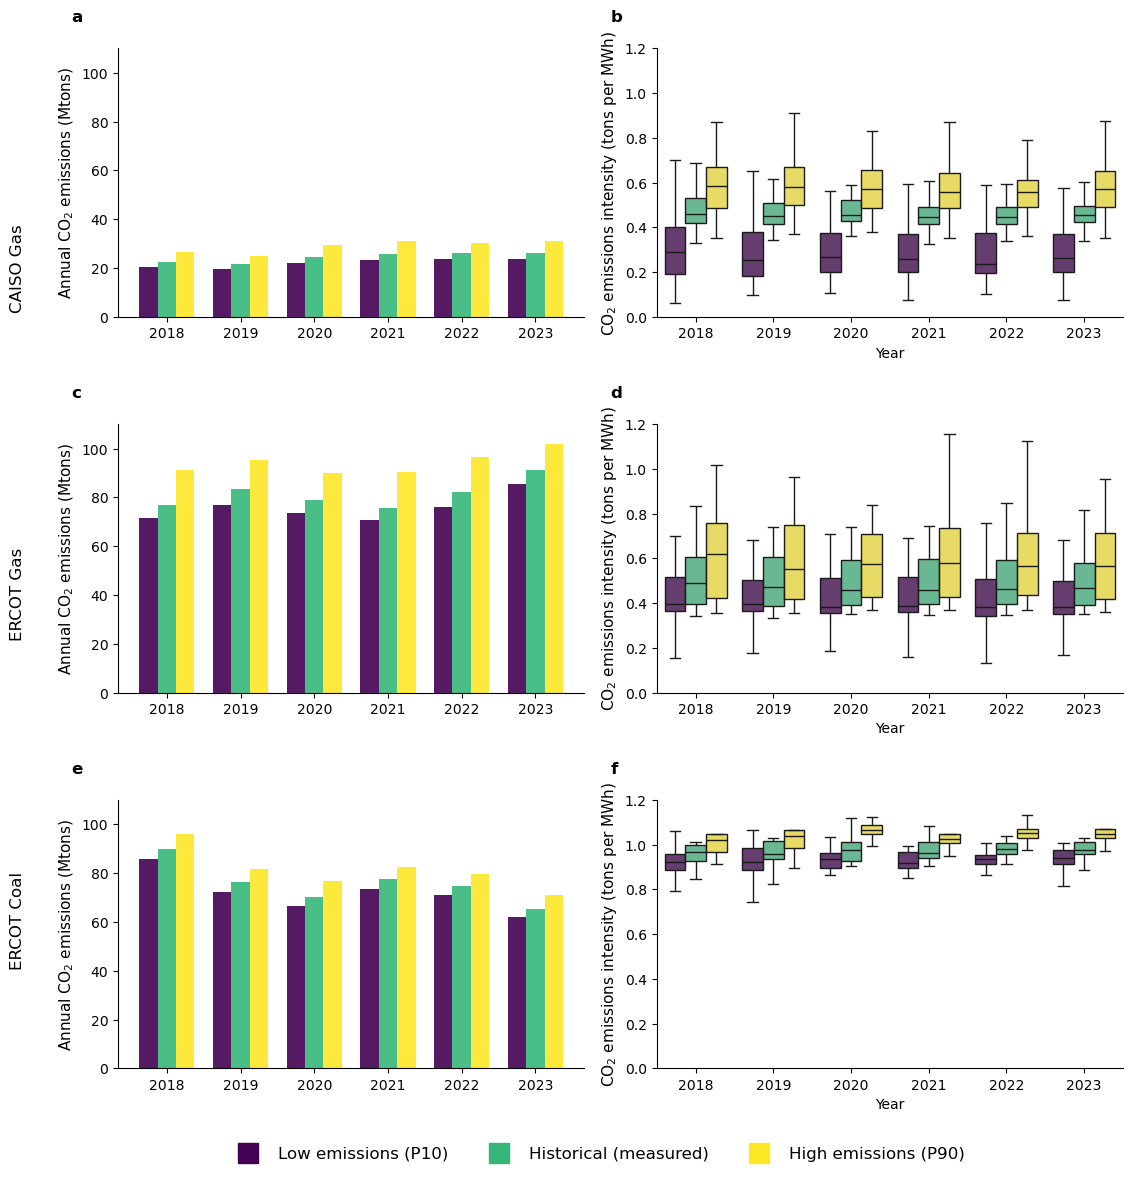

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import scoreatpercentile
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

# List of CSV file paths for each year
# Assuming files follow naming pattern like 'emissions-hourly-YEAR-REGION.csv'
ercot_files = glob.glob('/Users/dhruvsuri/Code/US_emissions_impacts/data/fig1/emissions-hourly-*-combined-ERCOT.csv')
caiso_files = glob.glob('/Users/dhruvsuri/Code/US_emissions_impacts/data/fig1/emissions-hourly-*-combined-CAISO.csv')

# Function to process files for a specific region and fuel type
def process_files(file_paths, region, fuel_types):
    df_summary_all_years = pd.DataFrame()
    
    for file_path in file_paths:
        # Load the data for each year
        df = pd.read_csv(file_path)
        
        # Preprocess the data
        df['Date'] = pd.to_datetime(df['Date'])
        df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')
        df['Datetime'] = df['Date'] + df['Hour']
        df['Year'] = df['Datetime'].dt.year
        
        # Filter for specified fuel type
        df = df[df['Primary Fuel Type'].isin(fuel_types)]
        
        if len(df) == 0:
            continue  # Skip if no data matches the fuel type
            
        columns = ['Facility ID', 'Unit ID', 'Datetime', 'CO2 Mass (short tons)', 'Gross Load (MW)', 'Operating Time', 'Year']
        df_mod = df[columns]
        
        # Drop 'Unit ID' and handle numeric conversions
        df_grouped = df_mod.drop(['Unit ID'], axis=1)
        df_grouped['Gross Load (MW)'] = pd.to_numeric(df_grouped['Gross Load (MW)'], errors='coerce')
        df_grouped['CO2 Mass (short tons)'] = pd.to_numeric(df_grouped['CO2 Mass (short tons)'], errors='coerce')
        
        # Group data by Facility ID and Datetime, summing emissions
        df_grouped = df_grouped.groupby(['Facility ID', 'Datetime']).sum().reset_index()
        
        # Convert CO2 Mass to metric tons and calculate EI
        df_grouped['CO2 Mass (short tons)'] = df_grouped['CO2 Mass (short tons)'] * 0.907185
        df_grouped['EI'] = df_grouped['CO2 Mass (short tons)'] / df_grouped['Gross Load (MW)']
        
        # Replace infinite and NaN values
        df_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_grouped.dropna(inplace=True)
        # drop when EI is 0
        df_grouped = df_grouped[df_grouped['EI'] != 0]
        
        # Group by Facility ID and calculate statistics
        df_summary = df_grouped.groupby('Facility ID').agg({
            'EI': ['mean', 'median', lambda x: scoreatpercentile(x, 90), lambda x: scoreatpercentile(x, 10)],
            'Gross Load (MW)': 'sum',
            'CO2 Mass (short tons)': 'sum'
        }).reset_index()

        # Rename columns
        df_summary.columns = ['Facility ID', 'Mean EI', 'Median EI', '90th Percentile EI', '10th Percentile EI', 
                             'Total Gross Load (MW)', 'Total CO2 Mass (short tons)']
        df_summary['Mean Annual EI'] = df_summary['Total CO2 Mass (short tons)'] / df_summary['Total Gross Load (MW)']
        df_summary['P90 emissions'] = df_summary['90th Percentile EI'] * df_summary['Total Gross Load (MW)']
        df_summary['P10 emissions'] = df_summary['10th Percentile EI'] * df_summary['Total Gross Load (MW)']
        
        # Add year column to summary
        df_summary['Year'] = df_grouped['Datetime'].dt.year.iloc[0]
        df_summary['Region'] = region
        df_summary['Fuel Type'] = '+'.join(fuel_types)
        
        # Append to the master DataFrame
        df_summary_all_years = pd.concat([df_summary_all_years, df_summary], ignore_index=True)
    
    return df_summary_all_years

# Process data for each region and fuel type
years = [2018, 2019, 2020, 2021, 2022, 2023]
coal_fuel = ['Coal']
gas_fuel = ['Natural Gas', 'Pipeline Natural Gas']

# Process data for each scenario
caiso_gas_data = process_files(caiso_files, 'CAISO', gas_fuel)
ercot_gas_data = process_files(ercot_files, 'ERCOT', gas_fuel)
ercot_coal_data = process_files(ercot_files, 'ERCOT', coal_fuel)

# Create a figure with 3 rows and 2 columns
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1])

# Viridis colors for consistency
colors_viridis = plt.cm.viridis(np.linspace(0, 1, 4))

# Function to create a row of plots (bar + box)
def create_row_plots(gs_row, data, row_title, panel_label):
    ax1 = plt.subplot(gs[gs_row, 0])  # Left plot (bar)
    ax2 = plt.subplot(gs[gs_row, 1])  # Right plot (box)
    
    # Bar plot for P10 emissions, Total CO2 Mass, and P90 emissions by year
    for i, year in enumerate(years):
        df_year = data[data['Year'] == year]
        if len(df_year) == 0:
            continue
        ax1.bar(i - 0.25, df_year['P10 emissions'].sum() / 1e6, width=0.25, color=colors_viridis[0])
        ax1.bar(i, df_year['Total CO2 Mass (short tons)'].sum() / 1e6, width=0.25, color=colors_viridis[2])
        ax1.bar(i + 0.25, df_year['P90 emissions'].sum() / 1e6, width=0.25, color=colors_viridis[3])
    
    # Box plot preparation
    df_melted = pd.melt(data, 
                        id_vars=['Year', 'Region', 'Fuel Type'], 
                        value_vars=['10th Percentile EI', 'Mean Annual EI', '90th Percentile EI'],
                        var_name='EI Type', 
                        value_name='EI Value')
    
    # Add transparency to box plot colors
    lightened_colors = [
        list(colors_viridis[0][:3]) + [0.1],
        list(colors_viridis[2][:3]) + [0.1],
        list(colors_viridis[3][:3]) + [0.1],
    ]
    
    # Create box plot
    sns.boxplot(x='Year', y='EI Value', hue='EI Type', data=df_melted, 
                ax=ax2, palette=lightened_colors, showfliers=False)
    
    # Adjust transparency of patches
    for patch in ax2.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
    
    for patch in ax1.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .9))
    
    # Style the plots
    ax1.set_xticks(range(len(years)))
    ax1.set_xticklabels(years)
    ax1.set_ylabel('Annual CO$_2$ emissions (Mtons)', fontsize=11)
    ax2.set_ylabel('CO$_2$ emissions intensity (tons per MWh)', fontsize=11)
    
    # Set y-limits
    ax1.set_ylim(0, 110)
    ax2.set_ylim(0, 1.2)
    
    # Remove spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Adjust tick label size
    ax1.tick_params(axis='x', labelsize=10)
    ax2.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    ax2.tick_params(axis='y', labelsize=10)
    
    # Hide legends
    ax1.legend().set_visible(False)
    ax2.legend().set_visible(False)
    
    # Add row title to the left of the plots
    fig.text(0.01, ax1.get_position().y0 + ax1.get_position().height/2, 
             row_title, ha='left', va='center', fontsize=12, rotation=90)
    
    # Add panel labels
    ax1.text(-0.1, 1.1, panel_label[0], transform=ax1.transAxes, 
             fontsize=12, fontweight='bold')
    ax2.text(-0.1, 1.1, panel_label[1], transform=ax2.transAxes,
             fontsize=12, fontweight='bold')
    
    return ax1, ax2

# Create each row
ax1_caiso, ax2_caiso = create_row_plots(0, caiso_gas_data, 'CAISO Gas', ('a', 'b'))
ax1_ercot_gas, ax2_ercot_gas = create_row_plots(1, ercot_gas_data, 'ERCOT Gas', ('c', 'd'))
ax1_ercot_coal, ax2_ercot_coal = create_row_plots(2, ercot_coal_data, 'ERCOT Coal', ('e', 'f'))

# Add a common legend at the bottom
legend_entries = [
    ('Low emissions (P10)', colors_viridis[0]),
    ('Historical (measured)', colors_viridis[2]),
    ('High emissions (P90)', colors_viridis[3])
]

# Create square legend handles
handles = [plt.Line2D([0], [0], marker='s', color=color, lw=0, markersize=14) 
           for label, color in legend_entries]
labels = [label for label, color in legend_entries]

# Position the legend outside the plot at the bottom, horizontal layout
fig.legend(handles, labels, loc='lower center', fontsize=12, 
           frameon=False, ncol=3, bbox_to_anchor=(0.5, 0.01), labelspacing=0.5)

# Tight layout with extra space at bottom for legend
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.subplots_adjust(left=0.1, bottom=0.1, top=0.95, hspace=0.4)

plt.savefig('emissions_comparison_three_rows.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/316045157.py:21: DtypeWarning: Columns (3,4,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/316045157.py:21: DtypeWarning: Columns (3,4,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/316045157.py:21: DtypeWarning: Columns (3,4,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/316045157.py:21: DtypeWarning: Columns (3,4,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_21127/316045157.py:21: DtypeWarning: Columns (3,4,25,28) have

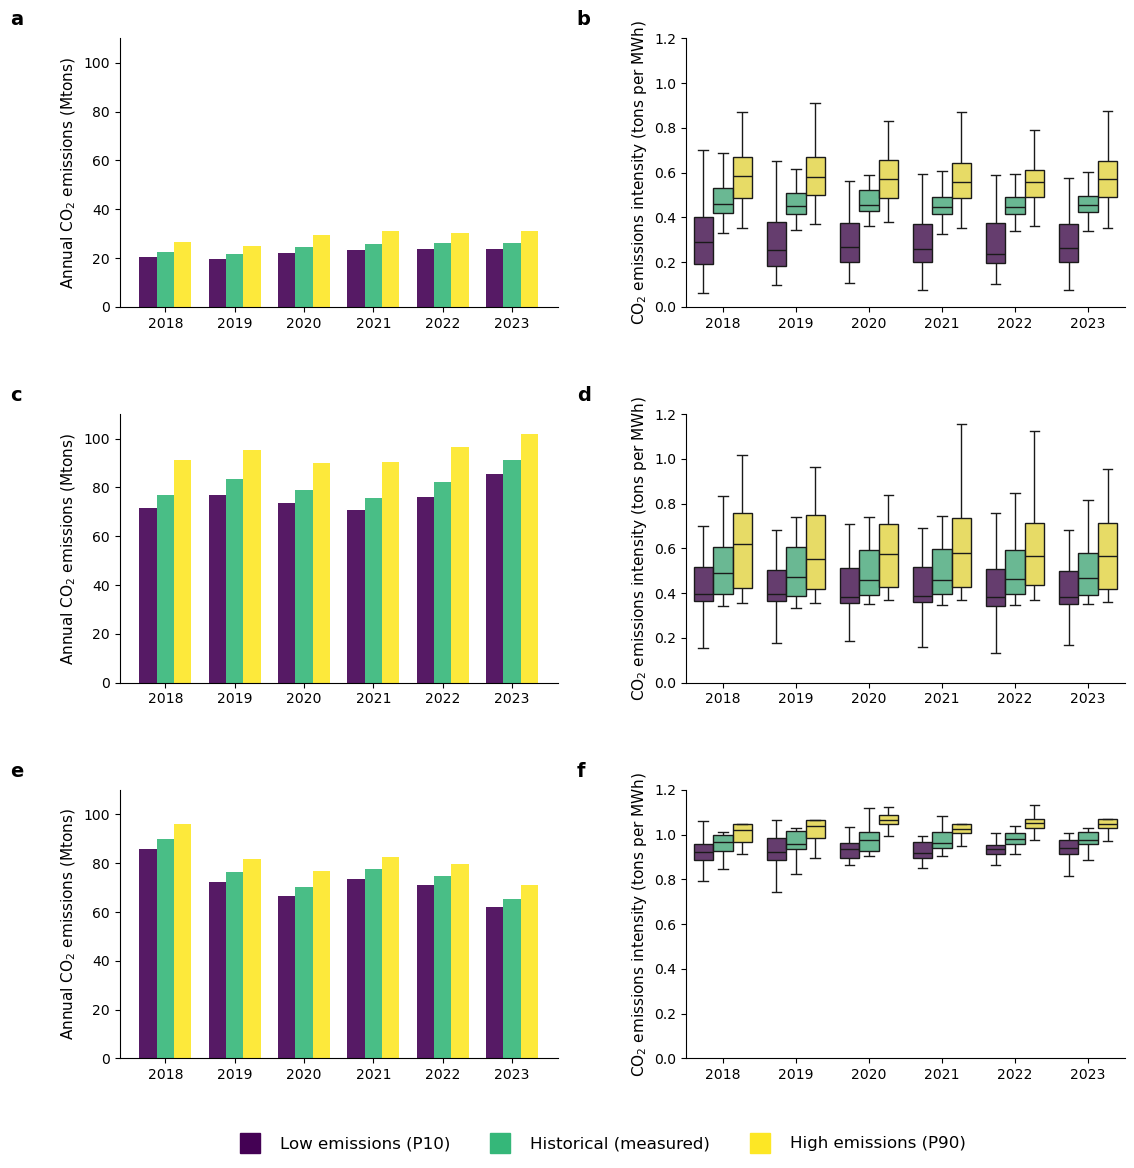

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import scoreatpercentile
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

# List of CSV file paths for each year
# Assuming files follow naming pattern like 'emissions-hourly-YEAR-REGION.csv'
ercot_files = glob.glob('/Users/dhruvsuri/Code/US_emissions_impacts/data/fig1/emissions-hourly-*-combined-ERCOT.csv')
caiso_files = glob.glob('/Users/dhruvsuri/Code/US_emissions_impacts/data/fig1/emissions-hourly-*-combined-CAISO.csv')

# Function to process files for a specific region and fuel type
def process_files(file_paths, region, fuel_types):
    df_summary_all_years = pd.DataFrame()
    
    for file_path in file_paths:
        # Load the data for each year
        df = pd.read_csv(file_path)
        
        # Preprocess the data
        df['Date'] = pd.to_datetime(df['Date'])
        df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')
        df['Datetime'] = df['Date'] + df['Hour']
        df['Year'] = df['Datetime'].dt.year
        
        # Filter for specified fuel type
        df = df[df['Primary Fuel Type'].isin(fuel_types)]
        
        if len(df) == 0:
            continue  # Skip if no data matches the fuel type
            
        columns = ['Facility ID', 'Unit ID', 'Datetime', 'CO2 Mass (short tons)', 'Gross Load (MW)', 'Operating Time', 'Year']
        df_mod = df[columns]
        
        # Drop 'Unit ID' and handle numeric conversions
        df_grouped = df_mod.drop(['Unit ID'], axis=1)
        df_grouped['Gross Load (MW)'] = pd.to_numeric(df_grouped['Gross Load (MW)'], errors='coerce')
        df_grouped['CO2 Mass (short tons)'] = pd.to_numeric(df_grouped['CO2 Mass (short tons)'], errors='coerce')
        
        # Group data by Facility ID and Datetime, summing emissions
        df_grouped = df_grouped.groupby(['Facility ID', 'Datetime']).sum().reset_index()
        
        # Convert CO2 Mass to metric tons and calculate EI
        df_grouped['CO2 Mass (short tons)'] = df_grouped['CO2 Mass (short tons)'] * 0.907185
        df_grouped['EI'] = df_grouped['CO2 Mass (short tons)'] / df_grouped['Gross Load (MW)']
        
        # Replace infinite and NaN values
        df_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_grouped.dropna(inplace=True)
        # drop when EI is 0
        df_grouped = df_grouped[df_grouped['EI'] != 0]
        
        # Group by Facility ID and calculate statistics
        df_summary = df_grouped.groupby('Facility ID').agg({
            'EI': ['mean', 'median', lambda x: scoreatpercentile(x, 90), lambda x: scoreatpercentile(x, 10)],
            'Gross Load (MW)': 'sum',
            'CO2 Mass (short tons)': 'sum'
        }).reset_index()

        # Rename columns
        df_summary.columns = ['Facility ID', 'Mean EI', 'Median EI', '90th Percentile EI', '10th Percentile EI', 
                             'Total Gross Load (MW)', 'Total CO2 Mass (short tons)']
        df_summary['Mean Annual EI'] = df_summary['Total CO2 Mass (short tons)'] / df_summary['Total Gross Load (MW)']
        df_summary['P90 emissions'] = df_summary['90th Percentile EI'] * df_summary['Total Gross Load (MW)']
        df_summary['P10 emissions'] = df_summary['10th Percentile EI'] * df_summary['Total Gross Load (MW)']
        
        # Add year column to summary
        df_summary['Year'] = df_grouped['Datetime'].dt.year.iloc[0]
        df_summary['Region'] = region
        df_summary['Fuel Type'] = '+'.join(fuel_types)
        
        # Append to the master DataFrame
        df_summary_all_years = pd.concat([df_summary_all_years, df_summary], ignore_index=True)
    
    return df_summary_all_years

# Process data for each region and fuel type
years = [2018, 2019, 2020, 2021, 2022, 2023]
coal_fuel = ['Coal']
gas_fuel = ['Natural Gas', 'Pipeline Natural Gas']

# Process data for each scenario
caiso_gas_data = process_files(caiso_files, 'CAISO', gas_fuel)
ercot_gas_data = process_files(ercot_files, 'ERCOT', gas_fuel)
ercot_coal_data = process_files(ercot_files, 'ERCOT', coal_fuel)

# Create a figure with 3 rows and 2 columns
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1])

# Viridis colors for consistency
colors_viridis = plt.cm.viridis(np.linspace(0, 1, 4))

# Function to create a row of plots (bar + box)
def create_row_plots(gs_row, data, row_title, panel_label):
    ax1 = plt.subplot(gs[gs_row, 0])  # Left plot (bar)
    ax2 = plt.subplot(gs[gs_row, 1])  # Right plot (box)
    
    # Bar plot for P10 emissions, Total CO2 Mass, and P90 emissions by year
    for i, year in enumerate(years):
        df_year = data[data['Year'] == year]
        if len(df_year) == 0:
            continue
        ax1.bar(i - 0.25, df_year['P10 emissions'].sum() / 1e6, width=0.25, color=colors_viridis[0])
        ax1.bar(i, df_year['Total CO2 Mass (short tons)'].sum() / 1e6, width=0.25, color=colors_viridis[2])
        ax1.bar(i + 0.25, df_year['P90 emissions'].sum() / 1e6, width=0.25, color=colors_viridis[3])
    
    # Box plot preparation
    df_melted = pd.melt(data, 
                        id_vars=['Year', 'Region', 'Fuel Type'], 
                        value_vars=['10th Percentile EI', 'Mean Annual EI', '90th Percentile EI'],
                        var_name='EI Type', 
                        value_name='EI Value')
    
    # Add transparency to box plot colors
    lightened_colors = [
        list(colors_viridis[0][:3]) + [0.1],
        list(colors_viridis[2][:3]) + [0.1],
        list(colors_viridis[3][:3]) + [0.1],
    ]
    
    # Create box plot
    sns.boxplot(x='Year', y='EI Value', hue='EI Type', data=df_melted, 
                ax=ax2, palette=lightened_colors, showfliers=False)
    
    # Adjust transparency of patches
    for patch in ax2.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
    
    for patch in ax1.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .9))
    
    # Style the plots
    ax1.set_xticks(range(len(years)))
    ax1.set_xticklabels(years)
    ax1.set_ylabel('Annual CO$_2$ emissions (Mtons)', fontsize=11)
    ax2.set_ylabel('CO$_2$ emissions intensity (tons per MWh)', fontsize=11)
    ax2.set_xlabel('')  # Remove x label from the right subplot
    
    # Set y-limits
    ax1.set_ylim(0, 110)
    ax2.set_ylim(0, 1.2)
    
    # Remove spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Adjust tick label size
    ax1.tick_params(axis='x', labelsize=10)
    ax2.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    ax2.tick_params(axis='y', labelsize=10)
    
    # Hide legends
    ax1.legend().set_visible(False)
    ax2.legend().set_visible(False)
    
    # Remove row titles
    
    # Add panel labels to the left of the y axis labels
    ax1.text(-0.25, 1.05, panel_label[0], transform=ax1.transAxes, 
             fontsize=14, fontweight='bold')
    ax2.text(-0.25, 1.05, panel_label[1], transform=ax2.transAxes,
             fontsize=14, fontweight='bold')
    
    return ax1, ax2

# Create each row
ax1_caiso, ax2_caiso = create_row_plots(0, caiso_gas_data, 'CAISO Gas', ('a', 'b'))
ax1_ercot_gas, ax2_ercot_gas = create_row_plots(1, ercot_gas_data, 'ERCOT Gas', ('c', 'd'))
ax1_ercot_coal, ax2_ercot_coal = create_row_plots(2, ercot_coal_data, 'ERCOT Coal', ('e', 'f'))

# Add a common legend at the bottom
legend_entries = [
    ('Low emissions (P10)', colors_viridis[0]),
    ('Historical (measured)', colors_viridis[2]),
    ('High emissions (P90)', colors_viridis[3])
]

# Create square legend handles
handles = [plt.Line2D([0], [0], marker='s', color=color, lw=0, markersize=14) 
           for label, color in legend_entries]
labels = [label for label, color in legend_entries]

# Position the legend outside the plot at the bottom, horizontal layout
fig.legend(handles, labels, loc='lower center', fontsize=12, 
           frameon=False, ncol=3, bbox_to_anchor=(0.5, 0.01), labelspacing=0.5)

# Tight layout with extra space at bottom for legend
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.subplots_adjust(left=0.1, bottom=0.1, top=0.95, hspace=0.4)

plt.savefig('emissions_comparison_three_rows.pdf', bbox_inches='tight')
plt.show()

In [9]:
plt.savefig('emissions_comparison_three_rows.pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [4]:
plt.show()